In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

This notebook is used to run the simulation experiments for fitting additive models with continuous features. 

# Create X data 

In [12]:
def sample_X(n,d):
    X = np.random.uniform(0,1.0,(n,d))
    return X

# Create response from linear model 

In [14]:
def linear_model(X,s,beta,sigma):
    
    '''
    This method is used to crete responses from a linear model with hard sparsity
    Parameters:
    X: X matrix
    s: sparsity 
    beta: coefficient vector. If beta not a vector, then assumed that 
    sigma: s.d. of added noise 
    Returns: 
    numpy array of shape (n)        
    '''
    
    def create_y(x,s,beta):
        linear_term = 0
        for i in range(s):
            linear_term += x[i]*beta
        return linear_term
    y_train = np.array([create_y(X[i, :],s,beta) for i in range(len(X))])
    y_train = y_train + sigma * np.random.randn((len(X)))
    return y_train

# Examine Generalisation performance for Sparse Linear Models 

In [2]:
def compute_theoretical_lower_bound(n,s,qmin,beta,sigma):
    return s*((beta**2)*qmin/12.0)**(s/(s+2))*(sigma**2/(4*n))**(1/(s+2))

In [40]:
n_train = [500,750,1000,1250,1500,1750,2000,2250,2500]
n_test = 500
d = 100
beta = 1
sigma = 0.1
sparsity = [1,5,10,15,20,25]
n_avg = 20

In [41]:
CART_results_matrix = []
CART_error_bar_matrix = []
RF_results_matrix = []
RF_error_bar_matrix = []
theoretical_lower_bound_matrix = []

In [42]:
#This cell's code is used to fit and predict for on linear model varying across the number of training samples/sparsity 
s = 10 
for (i,n) in enumerate(n_train):
        CART_result = []
        RF_result = []
        for j in range(n_avg):
            #Create data to fit models 
            X_train = sample_X(n,d)
            X_test = sample_X(n_test,d)
            y_train = linear_model(X_train,s,beta,sigma)
            y_test = linear_model(X_test,s,beta,sigma)
            #Fit and predict for CART/RF
            CART = DecisionTreeRegressor()
            CART.fit(X_train,y_train)
            CART_preds = CART.predict(X_test)
            CART_result.append(mean_squared_error(y_test,CART_preds))
            
            rf = RandomForestRegressor(n_estimators = 100,max_features = 0.33)
            rf.fit(X_train,y_train)
            rf_preds = rf.predict(X_test)
            RF_result.append(mean_squared_error(y_test,rf_preds))
        #Store Performance in matrix 
        av_CART_performance = statistics.mean(CART_result)
        sd_CART_performance = statistics.stdev(CART_result)
        av_RF_performance = statistics.mean(RF_result)
        sd_RF_performance = statistics.stdev(RF_result)
        CART_results_matrix.append(av_CART_performance)
        CART_error_bar_matrix.append(sd_CART_performance)
        RF_results_matrix.append(av_RF_performance)
        RF_error_bar_matrix.append(sd_RF_performance)
        theoretical_lower_bound_matrix.append(compute_theoretical_lower_bound(n,s,1.0,beta,sigma))

# Plot Performance 

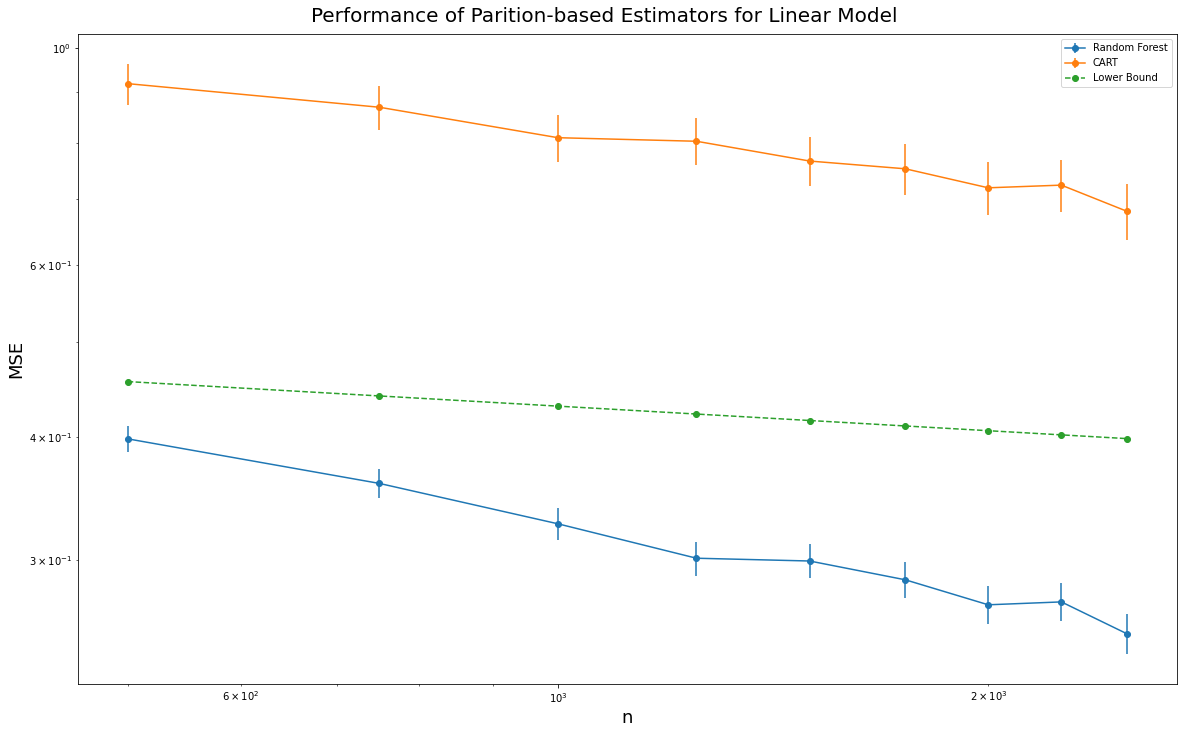

In [52]:
linear_lower_bound_fig,linear_lower_bound_axs = plt.subplots(1,1,figsize = (16,10),sharex = False,sharey = False)

linear_lower_bound_axs.errorbar(n_train,RF_results_matrix,yerr = sd_RF_performance,marker = 'o',label = 'Random Forest')
linear_lower_bound_axs.errorbar(n_train,CART_results_matrix,yerr = sd_CART_performance,marker = 'o',label = 'CART')
linear_lower_bound_axs.errorbar(n_train,theoretical_lower_bound_matrix,marker = 'o',label = 'Lower Bound',linestyle = 'dashed')
linear_lower_bound_axs.legend()
linear_lower_bound_axs.set_ylabel('MSE',fontsize = 18)
linear_lower_bound_axs.set_xlabel('n',fontsize = 18)
linear_lower_bound_fig.suptitle("Performance of Parition-based Estimators for Linear Model",fontsize = 20,y = 1.00)
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
plt.yscale('log')
plt.xscale('log')